#### Housekeeping

In [1]:
%reset -f

import pandas as pd
import numpy as np
# import folium   
import os
# import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 16})
from matplotlib.transforms import ScaledTranslation
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.ticker import AutoLocator
import seaborn as sns

import nrarfcn as nr
# https://gitlab.com/alexander_marder/earfcn
# https://pypi.org/project/earfcn/0.0.3/
from earfcn.convert import earfcn2freq

##### Bokeh plot function

In [2]:
import geopandas as gpd
from bokeh.plotting import figure, output_notebook, show, output_file
output_notebook()
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, HoverTool, WheelZoomTool, WMTSTileSource
from bokeh.palettes import Viridis256

Loading BokehJS ...

In [3]:
def plot_geo_scatter_map(df, value_col, title="Geo Map", colorbar_title="Value", unit=""):
    # Create GeoDataFrame and project to Web Mercator
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs="EPSG:4326").to_crs("EPSG:3857")
    gdf['x'], gdf['y'] = gdf.geometry.x, gdf.geometry.y

    # Setup Bokeh figure
    p = figure(
        title=title, width=800, height=500,
        x_axis_type="mercator", y_axis_type="mercator",
        tools="pan,reset,save",
        x_range=(gdf['x'].min()-300, gdf['x'].max()+300),
        y_range=(gdf['y'].min()-300, gdf['y'].max()+300)
    )
    p.add_tools(WheelZoomTool(zoom_on_axis=False))
    p.add_tile(WMTSTileSource(
        url='https://cartodb-basemaps-4.global.ssl.fastly.net/light_all/{Z}/{X}/{Y}.png',
        attribution="© CartoDB contributors")
    )

    # Color mapping and data source
    color_mapper = LinearColorMapper(palette=Viridis256, low=gdf[value_col].min(), high=gdf[value_col].max())
    source = ColumnDataSource(gdf[['x', 'y', value_col, 'Latitude', 'Longitude']])

    # Scatter points
    p.scatter(
        x='x', y='y', size=5, source=source,
        fill_color={'field': value_col, 'transform': color_mapper},
        line_color=None, fill_alpha=0.7
    )

    # Color bar and hover
    p.add_layout(ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title=colorbar_title), 'right')
    p.add_tools(HoverTool(tooltips=[
        ("Lat/Lon", "@{Latitude}, @{Longitude}"),
        (value_col, f"@{{{value_col}}} {unit}")
    ]))

    p.toolbar.active_drag = None
    p.toolbar.active_inspect = None

    show(p)

In [4]:
def plot_geo_binned_map(df, value_col, title="Geo Map", colorbar_title="Value", unit="", step_num=1e4):

    step_deg = step_num / 111.32e3  # convert meters to degrees
    to_bin = lambda x: np.floor(x / step_deg) * step_deg
    df = df.copy()
    df['lat_bin'] = to_bin(df['Latitude'])
    df['lon_bin'] = to_bin(df['Longitude'])
    binned = df.groupby(['lat_bin', 'lon_bin'])[value_col].max().reset_index()
    # binned = df.groupby(['lat_bin', 'lon_bin'])[value_col].mean().reset_index()
    def latlon_to_webm(lat, lon):
        k = 6378137
        x = k * np.radians(lon)
        y = k * np.log(np.tan(np.pi / 4 + np.radians(lat) / 2))
        return x, y
    binned['lat_max'] = binned['lat_bin'] + step_deg
    binned['lon_max'] = binned['lon_bin'] + step_deg
    x0, y0 = latlon_to_webm(binned['lat_bin'].values, binned['lon_bin'].values)
    x1, y1 = latlon_to_webm(binned['lat_max'].values, binned['lon_max'].values)
    binned['x0'], binned['x1'] = x0, x1
    binned['y0'], binned['y1'] = y0, y1

    # Setup Bokeh figure
    p = figure(
        title=title, width=800, height=500,
        x_axis_type="mercator", y_axis_type="mercator",
        tools="pan,reset,save",
        x_range=(min(x0)-100, max(x1)+100),
        y_range=(min(y0)-100, max(y1)+100)
    )
    p.add_tools(WheelZoomTool(zoom_on_axis=False))
    p.add_tile(WMTSTileSource(
        url='https://cartodb-basemaps-4.global.ssl.fastly.net/light_all/{Z}/{X}/{Y}.png',
        attribution="© CartoDB contributors")
    )

    # Color mapping and data source
    # color_mapper = LinearColorMapper(palette=Viridis256, low=binned[value_col].min(), high=binned[value_col].max())
    color_mapper = LinearColorMapper(palette=Viridis256, low=-135, high=-65)
    source = ColumnDataSource(binned)

    # Draw rectangles for each bin
    p.quad(
        top='y1', bottom='y0', left='x0', right='x1',
        source=source,
        fill_color={'field': value_col, 'transform': color_mapper},
        line_color=None, fill_alpha=0.7
    )

    # Color bar and hover
    p.add_layout(ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title=colorbar_title), 'right')
    p.add_tools(HoverTool(tooltips=[
        ("Lat Bin", "@lat_bin"),
        ("Lon Bin", "@lon_bin"),
        (value_col, f"@{{{value_col}}} {unit}")
    ]))

    p.toolbar.active_drag = None
    p.toolbar.active_inspect = None

    show(p)

In [5]:
def save_geo_binned_map(df, value_col, title="Geo Map", colorbar_title="Value", unit="", step_num=1e4, bounds=None):

    step_deg = step_num / 111.32e3  # convert meters to degrees
    to_bin = lambda x: np.floor(x / step_deg) * step_deg
    df = df.copy()
    df['lat_bin'] = to_bin(df['latitude'])
    df['lon_bin'] = to_bin(df['longitude'])
    # binned = df.groupby(['lat_bin', 'lon_bin'])[value_col].max().reset_index()
    binned = df.groupby(['lat_bin', 'lon_bin'])[value_col].mean().reset_index()
    def latlon_to_webm(lat, lon):
        k = 6378137
        x = k * np.radians(lon)
        y = k * np.log(np.tan(np.pi / 4 + np.radians(lat) / 2))
        return x, y
    binned['lat_max'] = binned['lat_bin'] + step_deg
    binned['lon_max'] = binned['lon_bin'] + step_deg
    x0, y0 = latlon_to_webm(binned['lat_bin'].values, binned['lon_bin'].values)
    x1, y1 = latlon_to_webm(binned['lat_max'].values, binned['lon_max'].values)
    binned['x0'], binned['x1'] = x0, x1
    binned['y0'], binned['y1'] = y0, y1

    if bounds:
        x_range = bounds[0]
        y_range = bounds[1]
    else:
        x_range = (min(x0) - 40, max(x1) + 40)
        y_range = (min(y0) - 40, max(y1) + 40)
        print(f"x_range: {x_range}")
        print(f"y_range: {y_range}")

    # Setup Bokeh figure
    p = figure(
        # title=title, ### FOR TITLE
        width=650, height=500,
        x_axis_type="mercator", y_axis_type="mercator",
        tools="pan,reset,save",
        x_range=x_range,
        y_range=y_range
    )

    p.add_tools(WheelZoomTool(zoom_on_axis=False))
    p.add_tile(WMTSTileSource(
        url='https://cartodb-basemaps-4.global.ssl.fastly.net/light_all/{Z}/{X}/{Y}.png',
        attribution="© CartoDB contributors")
    )
    # p.add_tile(WMTSTileSource(
    #     url='https://tile.openstreetmap.org/{Z}/{X}/{Y}.png',
    #     attribution="© OpenStreetMap contributors"),
    #     retina=True
    # )

    # Color mapping and data source
    # color_mapper = LinearColorMapper(palette=Viridis256, low=binned[value_col].min(), high=binned[value_col].max())
    color_mapper = LinearColorMapper(palette=Viridis256, low=-93, high=-38)
    source = ColumnDataSource(binned)

    # Draw rectangles for each bin
    p.quad(
        top='y1', bottom='y0', left='x0', right='x1',
        source=source,
        fill_color={'field': value_col, 'transform': color_mapper},
        line_color=None, fill_alpha=0.7
    )

    # Color bar and hover
    p.add_layout(ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0, 0), title=colorbar_title, title_text_font_size="20pt", major_label_text_font_size="18pt"), 'right')
    p.add_tools(HoverTool(tooltips=[
        ("Lat Bin", "@lat_bin"),
        ("Lon Bin", "@lon_bin"),
        (value_col, f"@{{{value_col}}} {unit}")
    ]))

    p.toolbar.active_drag = None
    p.toolbar.active_inspect = None

    p.xaxis.visible = False
    p.yaxis.visible = False

    output_file("binned_map.html")
    show(p)

##### Read Data

In [6]:
df_wifi_in = pd.read_csv('../_data/Spring2025_ArkansasNH/sigcap_wifi_in_nonload.csv')
df_wifi_out = pd.read_csv('../_data/Spring2025_ArkansasNH/sigcap_wifi_out_nonload.csv')

# df_wifi_in = df_wifi_in[df_wifi_in['ssid'] != 'Walmartwifi""']
# df_wifi_out = df_wifi_out[df_wifi_out['ssid'] != 'Walmartwifi""']

df_wifi_in_walmart = df_wifi_in[df_wifi_in['ssid'] == 'Walmartwifi']
df_wifi_out_walmart = df_wifi_out[df_wifi_out['ssid'] == 'Walmartwifi']

df_wifi_in_conn = df_wifi_in[df_wifi_in['connected'] == True]
df_wifi_out_conn = df_wifi_out[df_wifi_out['connected'] == True]

df_wifi_in_unconn = df_wifi_in[df_wifi_in['connected'] == False]
df_wifi_out_unconn = df_wifi_out[df_wifi_out['connected'] == False]

# del df_wifi_in, df_wifi_out

##### Map plotting

In [7]:
# temp = pd.concat([df_wifi_in_walmart, df_wifi_out_walmart])
# save_geo_binned_map(temp, value_col="rssi_dbm", title="Enterprise WiFi", colorbar_title="RSSI (dBm)", unit="dBm", step_num=6, bounds=[(-10484692.040246455, -10484312.041618733), (4327365.312535497, 4327742.706441018)])
# del temp

In [8]:
df_temp = pd.concat([df_wifi_in_walmart, df_wifi_out_walmart])
# df_temp = pd.concat([df_wifi_in, df_wifi_out])
df_temp_2ghz = df_temp[df_temp['primary_freq_mhz']<3000]
df_temp_5ghz = df_temp[df_temp['primary_freq_mhz']>=3000]
# print(df_temp['bssid'].unique().shape[0])
print(df_temp_2ghz['bssid'].unique())
print(df_temp_5ghz['bssid'].unique())

# save_geo_binned_map(df_temp_2ghz, value_col="rssi_dbm", title="Enterprise WiFi", colorbar_title="RSSI (dBm)", unit="dBm", step_num=6, bounds=[(-10484692.040246455, -10484312.041618733), (4327365.312535497, 4327742.706441018)])
# save_geo_binned_map(df_temp_5ghz, value_col="rssi_dbm", title="Enterprise WiFi", colorbar_title="RSSI (dBm)", unit="dBm", step_num=6, bounds=[(-10484692.040246455, -10484312.041618733), (4327365.312535497, 4327742.706441018)])

['d4:20:b0:d6:e5:c5' 'd4:20:b0:d6:ed:17' 'd4:dc:09:63:55:35'
 'd4:20:b0:e2:4b:a7' 'd4:20:b0:e2:4b:47' 'd4:20:b0:d6:46:07'
 'd4:20:b0:e2:4d:27' 'd4:dc:09:5e:50:15' 'd4:dc:09:5e:4f:b5'
 'd4:20:b0:d6:ec:87' 'd4:20:b0:e2:45:17' 'd4:20:b0:e2:4a:27']
['5c:5b:35:60:2c:58' 'd4:20:b0:d6:ec:fe' 'd4:20:b0:d6:e9:9e'
 'd4:20:b0:e2:4a:ce' '5c:5b:35:5f:f3:b7' 'd4:20:b0:d6:eb:7e'
 'd4:20:b0:d6:de:be' 'd4:20:b0:d6:e5:ac' 'd4:20:b0:d6:e8:1e'
 'd4:20:b0:e2:4b:5e' 'd4:20:b0:d6:f5:fe' 'd4:dc:09:78:74:0c'
 'd4:20:b0:d6:f6:8e' 'd4:20:b0:d6:ed:5e' '5c:5b:35:60:2d:d8'
 'd4:dc:09:63:55:1c' 'd4:20:b0:e2:4a:9e' '5c:5b:35:60:0a:f8'
 'd4:20:b0:e2:49:de' 'd4:20:b0:e2:48:5e' 'd4:20:b0:d6:eb:ae'
 'd4:20:b0:e2:40:de' 'd4:20:b0:e2:4c:4e' 'd4:20:b0:e2:3e:9e'
 'd4:20:b0:e2:48:8e' 'd4:20:b0:e2:4b:2e' 'd4:20:b0:e2:48:be'
 'd4:20:b0:d6:ec:6e' 'd4:20:b0:e2:4d:0e' 'd4:20:b0:d6:f6:2e'
 'd4:20:b0:e2:46:de' 'd4:20:b0:cf:f9:ce' 'd4:20:b0:d6:ee:de'
 'd4:20:b0:d6:f6:5e' '5c:5b:35:60:23:58' 'd4:20:b0:d6:45:ee'
 '5c:5b:35:60:26:b8' 'd

##### Plots

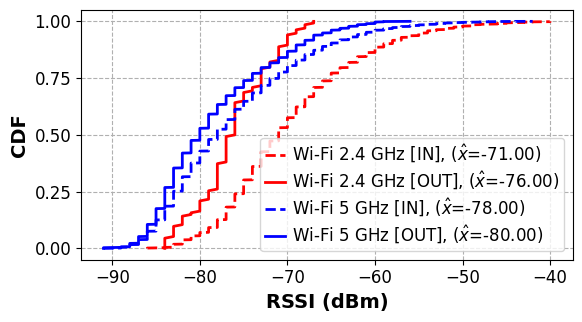

In [9]:
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.rcParams['text.usetex'] = False 

df_temp = df_wifi_in_walmart[df_wifi_in_walmart['primary_freq_mhz']<3000]["rssi_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"Wi-Fi 2.4 GHz [IN], ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="r")
del df_temp

df_temp = df_wifi_out_walmart[df_wifi_out_walmart['primary_freq_mhz']<3000]["rssi_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"Wi-Fi 2.4 GHz [OUT], ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='-', color="r")
del df_temp

df_temp = df_wifi_in_walmart[df_wifi_in_walmart['primary_freq_mhz']>=3000]["rssi_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"Wi-Fi 5 GHz [IN], ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="b")
del df_temp

df_temp = df_wifi_out_walmart[df_wifi_out_walmart['primary_freq_mhz']>=3000]["rssi_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"Wi-Fi 5 GHz [OUT], ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='-', color="b")
del df_temp

ax.set_xlabel('RSSI (dBm)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right', handlelength=1.2, handletextpad=0.4, borderpad=0.3, labelspacing=0.3)
plt.tight_layout()
# plt.savefig('figs/wifi_rssi_cdf.pdf', bbox_inches='tight')
plt.show()

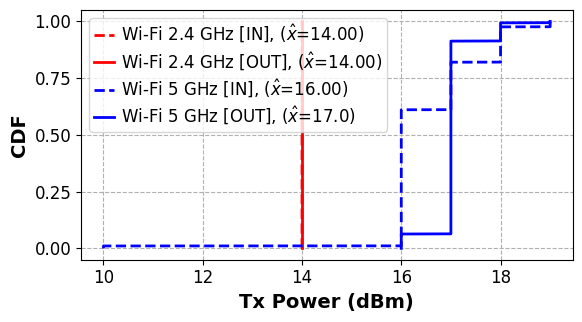

In [10]:
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.rcParams['text.usetex'] = False 

df_temp = df_wifi_in_walmart[df_wifi_in_walmart['primary_freq_mhz']<3000]["tx_power_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"Wi-Fi 2.4 GHz [IN], ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="r")
del df_temp

df_temp = df_wifi_out_walmart[df_wifi_out_walmart['primary_freq_mhz']<3000]["tx_power_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"Wi-Fi 2.4 GHz [OUT], ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='-', color="r")
del df_temp

df_temp = df_wifi_in_walmart[df_wifi_in_walmart['primary_freq_mhz']>=3000]["tx_power_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"Wi-Fi 5 GHz [IN], ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="b")
del df_temp

df_temp = df_wifi_out_walmart[df_wifi_out_walmart['primary_freq_mhz']>=3000]["tx_power_dbm"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"Wi-Fi 5 GHz [OUT], ($\hat{{x}}$={df_temp.median():.1f})",
    markersize=12, linewidth=2, linestyle='-', color="b")
del df_temp

ax.set_xlabel('Tx Power (dBm)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left', handlelength=1.2, handletextpad=0.4, borderpad=0.3, labelspacing=0.3)
plt.tight_layout()
# plt.savefig('figs/wifi_txpow_cdf.pdf', bbox_inches='tight')
plt.show()

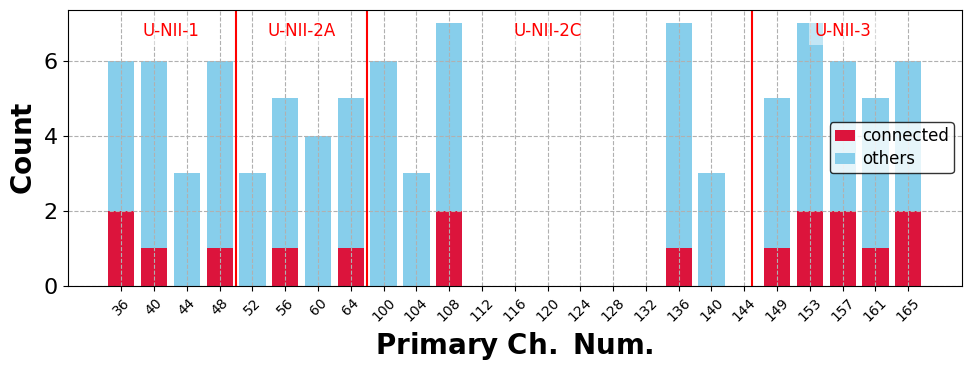

In [ ]:
df_focus = pd.concat([
    df_wifi_in_walmart[df_wifi_in_walmart['center_freq_mhz'] > 5000],
    df_wifi_out_walmart[df_wifi_out_walmart['center_freq_mhz'] > 5000]
])

chlist = [36,  40,  44,  48,  52,  56,  60,  64, 100, 104, 108, 112, 116,
          120, 124, 128, 132, 136, 140, 144, 149, 153, 157, 161, 165]


data_conn = df_focus[
    df_focus["connected"] == True
][["bssid", "primary_ch_num"]].groupby("primary_ch_num")["bssid"].nunique().reset_index()
for ch in chlist:
    if ch not in data_conn["primary_ch_num"].values:
        data_conn = pd.concat(
            [data_conn, pd.DataFrame({"primary_ch_num": [ch], "bssid": [0]})],
            ignore_index=True
        ).sort_values("primary_ch_num")

data_other = df_focus[
    df_focus["connected"] == False
][["bssid", "primary_ch_num"]].groupby("primary_ch_num")["bssid"].nunique().reset_index()
for ch in chlist:
    if ch not in data_other["primary_ch_num"].values:
        data_other = pd.concat(
            [data_other, pd.DataFrame({"primary_ch_num": [ch], "bssid": [0]})],
            ignore_index=True
        ).sort_values("primary_ch_num")

fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(np.arange(0, data_conn.shape[0]), data_conn["bssid"], color='crimson',
       label='connected')
ax.bar(np.arange(0, data_other.shape[0]), data_other["bssid"], color='skyblue',
       label='others', bottom=data_conn["bssid"])

label_y = .85 * (np.max(data_conn["bssid"]) + np.max(data_other["bssid"]))
ax.text(1.5, label_y, 'U-NII-1', fontsize=12, color='r', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax.axvline(x=3.5, color='r', linestyle='-')
ax.text(5.5, label_y, 'U-NII-2A', fontsize=12, color='r', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax.axvline(x=7.5, color='r', linestyle='-')
ax.text(13, label_y, 'U-NII-2C', fontsize=12, color='r', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax.axvline(x=19.25, color='r', linestyle='-')
ax.text(22, label_y, 'U-NII-3', fontsize=12, color='r', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
# ax.axvline(x=24.5, color='r', linestyle='-')
# ax.text(25, label_y, 'U-NII-4', fontsize=12, color='r', ha='center', va='center', rotation=90)

ax.set_xlabel(r'$\mathbf{Primary\ Ch.\ Num.}$', fontsize=20)
ax.set_ylabel(r'$\mathbf{Count}$', fontsize=20)
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')

# plt.title("# of unique indoor BSSID, 5 GHz", fontsize=16, fontweight='bold')
# plt.xlim(-1.5, 31.5)
# plt.ylim(0,8)
plt.xticks(np.arange(len(chlist)), chlist, fontsize=10, rotation=45)
plt.legend(fontsize=12, loc='center right', handlelength=1.2, handletextpad=0.4, borderpad=0.3, labelspacing=0.3, frameon=True, edgecolor='black')
plt.tight_layout()
# plt.savefig("figs/wifi_channel_count.pdf")
plt.show()
plt.close()

del df_focus, chlist, data_conn, data_other, ch, label_y, fig, ax

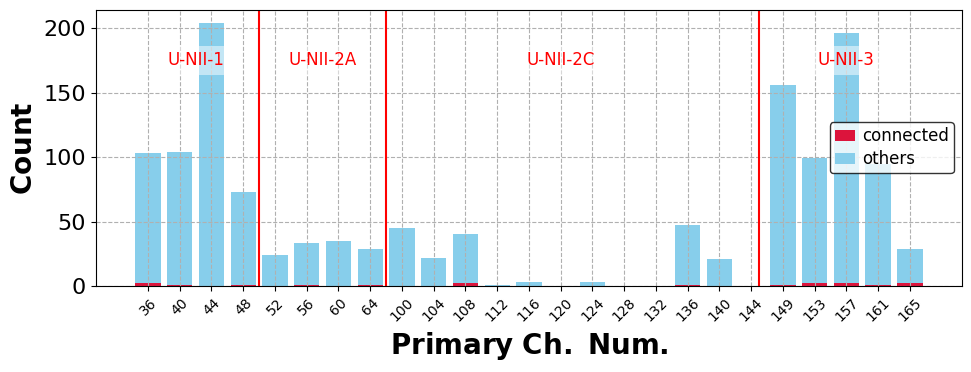

In [12]:
df_focus = pd.concat([
    df_wifi_in[
       (df_wifi_in['center_freq_mhz'] > 5000)
    ],
    df_wifi_out[df_wifi_out['center_freq_mhz'] > 5000]
])

chlist = [36,  40,  44,  48,  52,  56,  60,  64, 100, 104, 108, 112, 116,
          120, 124, 128, 132, 136, 140, 144, 149, 153, 157, 161, 165]


data_conn = df_focus[
    (df_focus["connected"] == True)
][["bssid", "primary_ch_num"]].groupby("primary_ch_num")["bssid"].nunique().reset_index()
for ch in chlist:
    if ch not in data_conn["primary_ch_num"].values:
        data_conn = pd.concat(
            [data_conn, pd.DataFrame({"primary_ch_num": [ch], "bssid": [0]})],
            ignore_index=True
        ).sort_values("primary_ch_num")

data_other = df_focus[
    df_focus["connected"] == False
][["bssid", "primary_ch_num"]].groupby("primary_ch_num")["bssid"].nunique().reset_index()
for ch in chlist:
    if ch not in data_other["primary_ch_num"].values:
        data_other = pd.concat(
            [data_other, pd.DataFrame({"primary_ch_num": [ch], "bssid": [0]})],
            ignore_index=True
        ).sort_values("primary_ch_num")

fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(np.arange(0, data_conn.shape[0]), data_conn["bssid"], color='crimson',
       label='connected')
ax.bar(np.arange(0, data_other.shape[0]), data_other["bssid"], color='skyblue',
       label='others', bottom=data_conn["bssid"])

label_y = .85 * (np.max(data_conn["bssid"]) + np.max(data_other["bssid"]))
ax.text(1.5, label_y, 'U-NII-1', fontsize=12, color='r', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax.axvline(x=3.5, color='r', linestyle='-')
ax.text(5.5, label_y, 'U-NII-2A', fontsize=12, color='r', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax.axvline(x=7.5, color='r', linestyle='-')
ax.text(13, label_y, 'U-NII-2C', fontsize=12, color='r', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
ax.axvline(x=19.25, color='r', linestyle='-')
ax.text(22, label_y, 'U-NII-3', fontsize=12, color='r', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
# ax.axvline(x=24.5, color='r', linestyle='-')
# ax.text(25, label_y, 'U-NII-4', fontsize=12, color='r', ha='center', va='center', rotation=90)

ax.set_xlabel(r'$\mathbf{Primary\ Ch.\ Num.}$', fontsize=20)
ax.set_ylabel(r'$\mathbf{Count}$', fontsize=20)
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')

# plt.title("# of unique indoor BSSID, 5 GHz", fontsize=16, fontweight='bold')
# plt.xlim(-1.5, 31.5)
# plt.ylim(0,8)
plt.xticks(np.arange(len(chlist)), chlist, fontsize=10, rotation=45)
plt.legend(fontsize=12, loc='center right', handlelength=1.2, handletextpad=0.4, borderpad=0.3, labelspacing=0.3, frameon=True, edgecolor='black')
plt.tight_layout()
# plt.savefig("figs/wifi_channel_count.pdf")
plt.show()
plt.close()

del df_focus, chlist, data_conn, data_other, ch, label_y, fig, ax

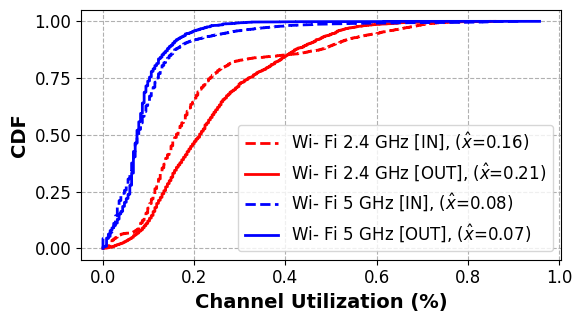

In [13]:
### Channel Utilization of ALL SSIDs

fig, ax = plt.subplots(figsize=(6, 3.5))
plt.rcParams['text.usetex'] = False 

df_temp = df_wifi_in[df_wifi_in['primary_freq_mhz']<3000]["ch_util"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"Wi- Fi 2.4 GHz [IN], ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="r")
del df_temp

df_temp = df_wifi_out[df_wifi_out['primary_freq_mhz']<3000]["ch_util"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"Wi- Fi 2.4 GHz [OUT], ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='-', color="r")
del df_temp

df_temp = df_wifi_in[df_wifi_in['primary_freq_mhz']>=3000]["ch_util"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"Wi- Fi 5 GHz [IN], ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='--', color="b")
del df_temp

df_temp = df_wifi_out[df_wifi_out['primary_freq_mhz']>=3000]["ch_util"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"Wi- Fi 5 GHz [OUT], ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='-', color="b")
del df_temp

ax.set_xlabel('Channel Utilization (%)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
# plt.savefig("figs/wifi_channel_util.pdf")
plt.show()

In [15]:
# ### Channel Utilization of ALL SSIDs

# fig, ax = plt.subplots(figsize=(6, 3.5))
# plt.rcParams['text.usetex'] = False 

# df_temp = df_wifi_in[df_wifi_in['primary_freq_mhz']<3000]["ch_util"].dropna().sort_values()
# ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
#     label=rf"Wi- Fi 2.4 GHz [IN], ($\hat{{x}}$={df_temp.median():.2f})",
#     markersize=12, linewidth=2, linestyle='--', color="r")
# del df_temp

# df_temp = df_wifi_out[df_wifi_out['primary_freq_mhz']<3000]["ch_util"].dropna().sort_values()
# ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
#     label=rf"Wi- Fi 2.4 GHz [OUT], ($\hat{{x}}$={df_temp.median():.2f})",
#     markersize=12, linewidth=2, linestyle='-', color="r")
# del df_temp

# df_temp = df_wifi_in[(df_wifi_in['primary_freq_mhz']>=3000) & (df_wifi_in['primary_ch_num'].isin([36, 40, 48, 56, 64, 108, 136, 149, 153, 157, 161, 165]))]["ch_util"].dropna().sort_values()
# ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
#     label=rf"Wi- Fi 5 GHz [IN], ($\hat{{x}}$={df_temp.median():.2f})",
#     markersize=12, linewidth=2, linestyle='--', color="b")
# del df_temp

# df_temp = df_wifi_out[(df_wifi_out['primary_freq_mhz']>=3000) & (df_wifi_out['primary_ch_num'].isin([36, 40, 48, 56, 64, 108, 136, 149, 153, 157, 161, 165]))]["ch_util"].dropna().sort_values()
# ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
#     label=rf"Wi- Fi 5 GHz [OUT], ($\hat{{x}}$={df_temp.median():.2f})",
#     markersize=12, linewidth=2, linestyle='-', color="b")
# del df_temp

# ax.set_xlabel('Channel Utilization (%)', fontsize=14, fontweight='bold')
# ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
# ax.yaxis.set_minor_locator(AutoLocator())
# ax.grid(True, linestyle='--', which='both', axis='both')
# plt.yticks(fontsize=12)
# plt.xticks(fontsize=12)
# plt.legend(fontsize=12, loc='lower right')
# plt.tight_layout()
# # plt.savefig("figs/wifi_channel_util.pdf")
# plt.show()